In [1]:
import bench_lib
import numpy as np
import matplotlib.pyplot as plt
import bench_plot_lib as plot_lib

import importlib
importlib.reload(bench_lib)
importlib.reload(plot_lib)

<module 'bench_plot_lib' from '/mydata/linux/linux/testing/page_cache_ext/bench_plot_lib.py'>

In [2]:
GiB = 2**30

SYS_NAME = "cache_ext"
iops_select_fn = lambda r: r["jobs"][0]["read"]["iops"]


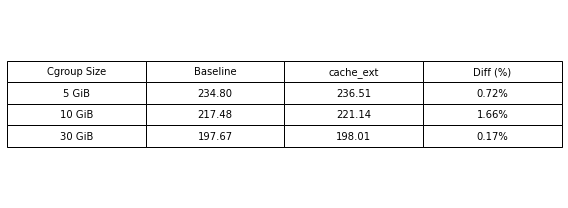

In [3]:
# Plot fio results

fio_results = bench_lib.parse_results_file("fio_results.json", bench_lib.BenchResults)

cgroup_size = 30 * GiB
cgroup_sizes = [5 * GiB, 10 * GiB, 20 * GiB, 30 * GiB]

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
}

baseline_iops = {}
cache_ext_iops = {}
iops_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_iops[cgroup_size] = plot_lib.results_select(fio_results, baseline_config_match, iops_select_fn)
    baseline_iops[cgroup_size] = np.mean(baseline_iops[cgroup_size])
    cache_ext_iops[cgroup_size] = plot_lib.results_select(fio_results, cache_ext_config_match, iops_select_fn)
    cache_ext_iops[cgroup_size] = np.mean(cache_ext_iops[cgroup_size])
    iops_diff[cgroup_size] = (cache_ext_iops[cgroup_size] - baseline_iops[cgroup_size]) / cache_ext_iops[cgroup_size] * 100


baseline_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_cpu = plot_lib.results_select(fio_results, baseline_config_match, lambda r: r["cpu_usage"])
    baseline_cpu_usage[cgroup_size] = np.mean(baseline_cpu) / baseline_iops[cgroup_size] * 10**6

    cache_ext_config_match["cgroup_size"] = cgroup_size
    cache_ext_cpu = plot_lib.results_select(fio_results, cache_ext_config_match, lambda r: r["cpu_usage"])
    cache_ext_cpu_usage[cgroup_size] = np.mean(cache_ext_cpu) / cache_ext_iops[cgroup_size] * 10**6

    cpu_usage_diff[cgroup_size] = (cache_ext_cpu_usage[cgroup_size] - baseline_cpu_usage[cgroup_size]) / cache_ext_cpu_usage[cgroup_size] * 100

# print(baseline_cpu_usage)

# Put the CPU overhead data in a table
table_data = []

# Add a row for CPU usage
table_data.extend([
    ["5 GiB", f"{baseline_cpu_usage[5*GiB]:.2f}", f"{cache_ext_cpu_usage[5*GiB]:.2f}", f"{cpu_usage_diff[5*GiB]:.2f}%"],
    ["10 GiB", f"{baseline_cpu_usage[10*GiB]:.2f}", f"{cache_ext_cpu_usage[10*GiB]:.2f}", f"{cpu_usage_diff[10*GiB]:.2f}%"],
    ["30 GiB", f"{baseline_cpu_usage[30*GiB]:.2f}", f"{cache_ext_cpu_usage[30*GiB]:.2f}", f"{cpu_usage_diff[30*GiB]:.2f}%"],
])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Cgroup Size", "Baseline", SYS_NAME, "Diff (%)"],
                  cellLoc="center",
                  loc="center")
table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# YCSB results

ycsb_results = bench_lib.parse_results_file("ycsb_results.json", bench_lib.BenchResults)
ycsb_results[0].results.__dict__

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]
config_matches = bench_lib.add_config_option("cgroup_size", [5 * GiB, 10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)
display(config_matches)

plot_lib.leveldb_plot_ycsb_results(config_matches, ycsb_results, filename="leveldb_ycsb_results.png", bench_types=["ycsb_a", "ycsb_c"])

[{'name': 'leveldb_benchmark',
  'cgroup_size': 5368709120,
  'cgroup_name': 'baseline_test'},
 {'name': 'leveldb_benchmark',
  'cgroup_size': 5368709120,
  'cgroup_name': 'cache_ext_test'},
 {'name': 'leveldb_benchmark',
  'cgroup_size': 10737418240,
  'cgroup_name': 'baseline_test'},
 {'name': 'leveldb_benchmark',
  'cgroup_size': 10737418240,
  'cgroup_name': 'cache_ext_test'}]

{'name': 'leveldb_benchmark', 'cgroup_size': 5368709120, 'cgroup_name': 'baseline_test', 'benchmark': 'ycsb_a'}
[]


AssertionError: len(y_res) = 0